In [11]:
# import osmnx as ox
# import matplotlib.pyplot as plt
# from shapely.geometry import box

# # Set up the bounding box
# #north, south, east, west = 41.0037, 36.9924, -102.0415, -109.0448
# north, south, east, west = 41.0037, 38.9924, -102.0415, -104.0448

# # Define smaller geographic chunks by creating smaller bounding boxes
# # This splits the large box into smaller sections
# lat_points = [north, (north+south)/2, south]
# lon_points = [west, (west+east)/2, east]
# bbox_list = [box(lon_points[i], lat_points[j], lon_points[i+1], lat_points[j+1]) for i in range(len(lon_points)-1) for j in range(len(lat_points)-1)]

# # Define the custom filter for waterways
# custom_filter = '["waterway"~"river|canal|stream|lake"]'

# # Download and plot each smaller area separately
# fig, ax = plt.subplots(figsize=(10, 10))
# for bbox in bbox_list:
#     graph = ox.graph_from_bbox(north=bbox.bounds[3], south=bbox.bounds[1], east=bbox.bounds[2], west=bbox.bounds[0],
#                                custom_filter=custom_filter, simplify=True, retain_all=True, truncate_by_edge=True)
#     gdf = ox.graph_to_gdfs(graph, nodes=False)
#     gdf.plot(ax=ax, linewidth=1, edgecolor='blue')

# plt.title('Waterways in Large Area')
# plt.show()


C:\Users\smdur\anaconda3\envs\globalpcl\lib\site-packages\osmnx\_overpass.py:245: UserWarning: This area is 108 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


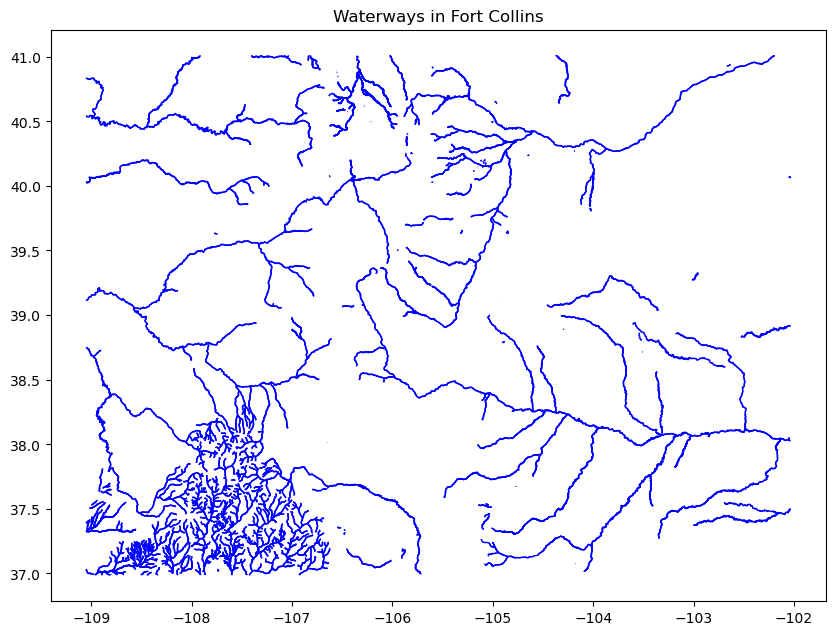

In [16]:
import osmnx as ox
import matplotlib.pyplot as plt

#north, south, east, west = 40.6369, 40.5531, -105.0049, -105.0763  
#north, south, east, west = 41.0023, 40.5328, -104.9826, -105.6780
north, south, east, west = 41.0037, 36.9924, -102.0415, -109.0448
#north, south, east, west = 41.0037, 36.9924, -102.0415, -104.0448

# Define the custom filter for waterways
custom_filter = '["waterway"~"river|streams|canals"]'



#ox.config(overpass_settings='[out:json][timeout:180][max_query_area_size:100000]')

# Get the waterway network for the specified bounding box using the custom filter
#graph = ox.graph_from_bbox(north, south, east, west, custom_filter=custom_filter, simplify=True, retain_all=True, truncate_by_edge=True)
bbox = (north, south, east, west)  # your current north, south, east, west values
graph = ox.graph_from_bbox(bbox=bbox, custom_filter=custom_filter, simplify=True, retain_all=True, truncate_by_edge=True)


gdf = ox.graph_to_gdfs(graph, nodes=False)

# Convert the graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph)

# Plot the waterway network
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=1, edgecolor='blue')
plt.title('Waterways in Fort Collins')
plt.show()

In [17]:

import rasterio
from rasterio.features import rasterize
from rasterio.windows import from_bounds
import numpy as np
import scipy.ndimage

# Assuming 'gdf' is your correctly located GeoDataFrame
# Define the bounding box coordinates
#north, south, east, west = 40.7369, 40.5531, -105.0149, -105.0763

in_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\Input\\pcl_west_wgs_CO.tif'
# Load the reference TIFF to use for transformations and metadata
with rasterio.open(in_path) as src:
    meta = src.meta.copy()

    # Convert geographic coordinates to pixel coordinates
    window = from_bounds(west, south, east, north, src.transform)
    transform = rasterio.windows.transform(window, src.transform)

    # Correct the window dimensions to integers
    window_width = int(window.width)
    window_height = int(window.height)

    # Create an empty raster array for the size of the window
    raster = np.zeros((window_height, window_width), dtype=np.uint8)

    # Rasterize directly into the window shape
    shapes = ((geom, 1) for geom in gdf['geometry'])
    burned = rasterize(shapes, out=raster, fill=0, transform=transform, all_touched=True)

    # Compute the Euclidean distance from each cell to the nearest non-zero cell
    distance_grid = scipy.ndimage.distance_transform_edt(burned == 0)

    # Prepare metadata for saving the distance grid
    clipped_meta = meta.copy()
    clipped_meta.update({
        "driver": "GTiff",
        "height": window_height,
        "width": window_width,
        "transform": transform,
        "dtype": rasterio.float32,
        "count": 1,
        "compress": 'lzw'
    })

    # Save the distance grid to a new TIFF file
    with rasterio.open('C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\Input\\distance_grid_clipped_Roads_CO_river.tif', 'w', **clipped_meta) as dst:
        dst.write(distance_grid.astype(np.float32), 1)

C:\Users\smdur\AppData\Local\Temp\ipykernel_10700\1270619072.py:11: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  graph = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify=True)
C:\Users\smdur\anaconda3\envs\globalpcl\lib\site-packages\osmnx\_overpass.py:245: UserWarning: This area is 108 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


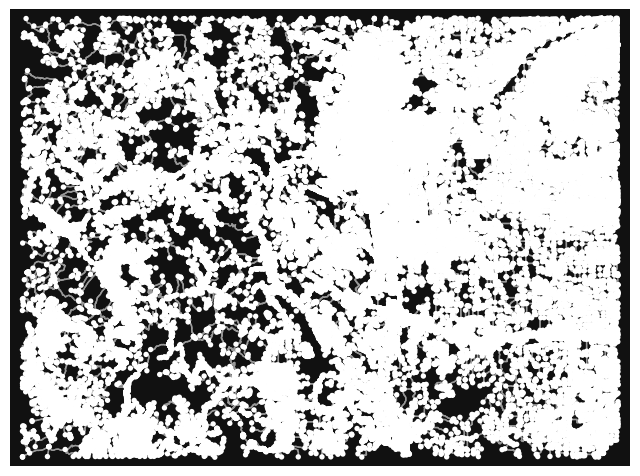

In [18]:
import osmnx as ox
import matplotlib.pyplot as plt

# Define the bounding box coordinates (south, north, west, east) for Fort Collins
#north, south, east, west = 40.6369, 40.5531, -105.0049, -105.0763  # Adjust these coordinates as needed
#north, south, east, west = 40.7369, 40.5531, -105.0149, -105.0763
north, south, east, west = 41.0037, 36.9924, -102.0415, -109.0448


# Get the road network for the specified bounding box and network type ('drive', 'walk', 'bike')
graph = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify=True)


gdf = ox.graph_to_gdfs(graph, nodes=False)


# Plot the road network
ox.plot_graph(graph)
plt.show()

In [19]:

import rasterio
from rasterio.features import rasterize
from rasterio.windows import from_bounds
import numpy as np
import scipy.ndimage

# Assuming 'gdf' is your correctly located GeoDataFrame
# Define the bounding box coordinates
#north, south, east, west = 40.7369, 40.5531, -105.0149, -105.0763

in_path = 'C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\Input\\pcl_west_wgs_CO.tif'
# Load the reference TIFF to use for transformations and metadata
with rasterio.open(in_path) as src:
    meta = src.meta.copy()

    # Convert geographic coordinates to pixel coordinates
    window = from_bounds(west, south, east, north, src.transform)
    transform = rasterio.windows.transform(window, src.transform)

    # Correct the window dimensions to integers
    window_width = int(window.width)
    window_height = int(window.height)

    # Create an empty raster array for the size of the window
    raster = np.zeros((window_height, window_width), dtype=np.uint8)

    # Rasterize directly into the window shape
    shapes = ((geom, 1) for geom in gdf['geometry'])
    burned = rasterize(shapes, out=raster, fill=0, transform=transform, all_touched=True)

    # Compute the Euclidean distance from each cell to the nearest non-zero cell
    distance_grid = scipy.ndimage.distance_transform_edt(burned == 0)

    # Prepare metadata for saving the distance grid
    clipped_meta = meta.copy()
    clipped_meta.update({
        "driver": "GTiff",
        "height": window_height,
        "width": window_width,
        "transform": transform,
        "dtype": rasterio.float32,
        "count": 1,
        "compress": 'lzw'
    })

    # Save the distance grid to a new TIFF file
    with rasterio.open('C:\\Users\\smdur\\OneDrive\\Desktop\\GLOBALPCL\\Input\\distance_grid_clipped_Roads_CO_roads.tif', 'w', **clipped_meta) as dst:
        dst.write(distance_grid.astype(np.float32), 1)